# CRPS Summary

This plots data written by the `process_uncertainties.py` script.

In [43]:
import sys

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skewnorm

sys.path.append("..")
from constants import MIN_DAYSAHEAD, MAX_DAYSAHEAD, BIN_FREQ_PER_DAY

sns.set()

In [14]:
dfs = {}

for i in range(MIN_DAYSAHEAD, MAX_DAYSAHEAD + 1):
    dfs[i] = pd.read_csv(f"../data/processed/rfr/processed_daysahead{i}_R000.csv")

dfs[1].head()

,current_time,forward_time,forward_Vp_pred,forward_Vp_obs,forward_loc,forward_scale,forward_shape,forward_crps
0,2010-01-02 12:00:00,2010-01-03 06:00:00,376.450000,289.79,266.535042,106.253418,6.970238,30.677169
1,2010-01-02 18:00:00,2010-01-03 12:00:00,369.400000,290.97,261.458965,108.082417,5.759502,27.745636
2,2010-01-03 00:00:00,2010-01-03 18:00:00,359.800000,305.76,253.275783,108.224999,5.068823,18.269994
3,2010-01-03 06:00:00,2010-01-04 00:00:00,370.450000,298.70,252.429388,112.337343,5.811849,21.429466
4,2010-01-03 12:00:00,2010-01-04 06:00:00,363.533333,285.85,258.251383,120.541284,5.824481,34.029235


In [18]:
rows = []

for daysahead, df in dfs.items():
    rows.append([daysahead, np.mean(df.forward_crps), np.median(df.forward_crps)])

pd.set_option("display.float_format", "{:.2f}".format)
pd.DataFrame(rows, columns=["Days Ahead", "CRPS Mean", "CRPS Median"]).T

,0,1,2,3,4,5,6
Days Ahead,1.00,2.00,3.00,4.00,5.00,6.00,7.00
CRPS Mean,37.86,45.15,47.50,49.22,50.44,51.63,54.61
CRPS Median,24.73,29.65,31.72,33.23,33.42,35.05,35.45


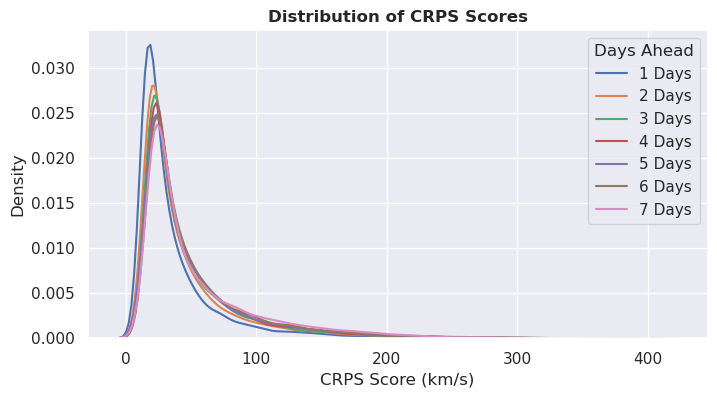

In [4]:
df_list = []


plt.figure(figsize=(8, 4))
for daysahead, df in dfs.items():
    sns.kdeplot(df.forward_crps, label=f"{daysahead} Days")

plt.xlabel(r"CRPS Score (km/s)")
plt.legend()
plt.gca().get_legend().set_title("Days Ahead")
plt.title("Distribution of CRPS Scores", fontweight="bold")

plt.savefig("../plots/crps_summary.png", dpi=300)

In [50]:
rows = []

for i in range(1, 8):
    row = []
    row.append(i)

    loc = dfs[i].forward_loc
    scale = dfs[i].forward_scale
    shape = dfs[i].forward_shape

    delta = shape / np.sqrt(1 + shape**2)
    mean = loc + scale * delta * np.sqrt(2 / np.pi)

    # RMS of Realization 0 (Raw)
    row.append(
        np.sqrt(np.mean(np.square(dfs[i].forward_Vp_pred - dfs[i].forward_Vp_obs)))
    )

    # RMS of Realization 0 (Skew Norm Mean)
    row.append(np.sqrt(np.mean(np.square(mean - dfs[i].forward_Vp_obs))))

    # RMS of Realization 0 (Skew Norm Median)
    medians = []
    for _, r in list(dfs[i].iterrows()):
        median = skewnorm(
            r.forward_shape, loc=r.forward_loc, scale=r.forward_scale
        ).interval(0)[0]
        medians.append(median)
    medians = np.array(medians)

    row.append(np.sqrt(np.mean(np.square(medians - dfs[i].forward_Vp_obs))))
    rows.append(row)

In [52]:
df_rmse = pd.DataFrame(
    rows,
    columns=["Days Ahead", "WSA Point Parcel", "Skew Norm Mean", "Skew Norm Median"],
)
df_rmse.T

,0,1,2,3,4,5,6
Days Ahead,1.00,2.00,3.00,4.00,5.00,6.00,7.00
WSA Point Parcel,104.69,103.33,103.49,104.99,107.69,108.74,114.67
Skew Norm Mean,71.47,83.69,87.26,90.07,92.57,94.45,99.61
Skew Norm Median,72.18,84.56,88.17,90.80,93.68,95.16,100.27
